In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
nombre_csv = 1
de = pd.read_csv(f'Datos_entrenamiento/{nombre_csv}_e.csv')
dp = pd.read_csv(f'Datos_prueba/{nombre_csv}_p.csv')

# Estandarización

In [3]:
# Contamos las ocurrencias de cada nivel de estrés en la nueva columna
conteo_nivel_estresde = de['Nivel_estres_1'].value_counts()
conteo_nivel_estresdp = dp['Nivel_estres_1'].value_counts()
# Mostramos el resultado
print(conteo_nivel_estresde)
print(conteo_nivel_estresdp)

Nivel_estres_1
normal     2784
alerta      792
peligro     360
Name: count, dtype: int64
Nivel_estres_1
normal     1896
alerta      480
peligro     120
Name: count, dtype: int64


In [4]:
# Crear un diccionario para mapear cada categoría única en la columna 'nivel_estres' a un número
mapping = {'normal': 0, 'alerta': 1, 'peligro': 2}
# Mapear las categorías a números utilizando el método map de pandas
de['Nivel_estres_1'] = de['Nivel_estres_1'].map(mapping)
dp['Nivel_estres_1'] = dp['Nivel_estres_1'].map(mapping)
de['Nivel_estres_2'] = de['Nivel_estres_2'].map(mapping)
dp['Nivel_estres_2'] = dp['Nivel_estres_2'].map(mapping)

In [5]:
# # Crear una instancia del objeto StandardScaler
# scaler = StandardScaler()

# # Seleccionar las columnas del DataFrame que se van a escalar
# columns_to_scale = ['H', 'T', 'RH', 'WS', 'RS', 'ITH', 'wind_chill']

# # Aplicar la transformación de escala a las columnas seleccionadas y actualizar el DataFrame
# vc[columns_to_scale] = scaler.fit_transform(vc[columns_to_scale])
# vc

# Aplicación de CNN

In [6]:
# # Separar características y etiquetas del conjunto de entrenamiento
# X_train = de[['period eating','period other','period resting','period rumination']].values
# y_train = de['Nivel_estres_1'].values
# # Separar características y etiquetas del conjunto de prueba
# X_test = dp[['period eating','period other','period resting','period rumination']].values
# y_test = dp['Nivel_estres_1'].values


In [7]:
# Separar características y etiquetas del conjunto de entrenamiento
X_train = de[['period eating_count','period other_count','period resting_count','period rumination_count']].values
y_train = de['Nivel_estres_2'].values
# Separar características y etiquetas del conjunto de prueba
X_test = dp[['period eating_count','period other_count','period resting_count','period rumination_count']].values
y_test = dp['Nivel_estres_2'].values

In [8]:
# Estandarizar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
# Definir la arquitectura del modelo CNN
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(X_train.shape[1], 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(300, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')  # 3neuronas para los 3 niveles de estres
])

# Compilar el modelo
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
# Entrenar el modelo
history = model.fit(X_train_scaled[..., np.newaxis], y_train, epochs=50, validation_data=(X_test_scaled[..., np.newaxis], y_test))

Epoch 1/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8906 - loss: 0.5573 - val_accuracy: 0.9808 - val_loss: 0.1687
Epoch 2/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9182 - loss: 0.3300 - val_accuracy: 0.9808 - val_loss: 0.1765
Epoch 3/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9168 - loss: 0.3272 - val_accuracy: 0.9808 - val_loss: 0.1487
Epoch 4/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9220 - loss: 0.3029 - val_accuracy: 0.9808 - val_loss: 0.1488
Epoch 5/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9088 - loss: 0.3458 - val_accuracy: 0.9808 - val_loss: 0.1378
Epoch 6/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9215 - loss: 0.3018 - val_accuracy: 0.9772 - val_loss: 0.1765
Epoch 7/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9120 - loss: 0.3232 - val_accuracy: 0.9796 - val_loss: 0.1537
Epoch 8/50
123/123 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9108 - loss: 0.3304 - val_accuracy: 0.

In [17]:
# Predecir las clases del conjunto de prueba
y_pred = model.predict(X_test[..., np.newaxis])
# Obtener la clase predicha para cada instancia
y_pred = np.argmax(y_pred, axis=1)

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [18]:

# Contamos las ocurrencias de cada nivel de estrés
valores_unicos, conteos = np.unique(y_test, return_counts=True)
valores_unicos1, conteos1 = np.unique(y_pred, return_counts=True)
# Combina los valores únicos y sus conteos en un diccionario para facilitar la visualización
ocurrencias = dict(zip(valores_unicos, conteos))
ocurrenciaspre = dict(zip(valores_unicos1, conteos1))
# Mostramos el resultado
#print(conteo_nivel_estres)
print(ocurrencias)
print(ocurrenciaspre)

{0: 2448, 1: 24, 2: 24}
{0: 2496}


# Evaluación

In [19]:
from sklearn.preprocessing import label_binarize

# Calcular las métricas de evaluación
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

y_pred= label_binarize(y_pred, classes=[0, 1, 2])

# Calcular el AUC
roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr')

# Mostrar métricas
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC AUC:", roc_auc)

Accuracy: 0.9807692307692307
Precision: 0.9619082840236686
Recall: 0.9807692307692307
F1 Score: 0.9712471994025392
ROC AUC: 0.5


c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


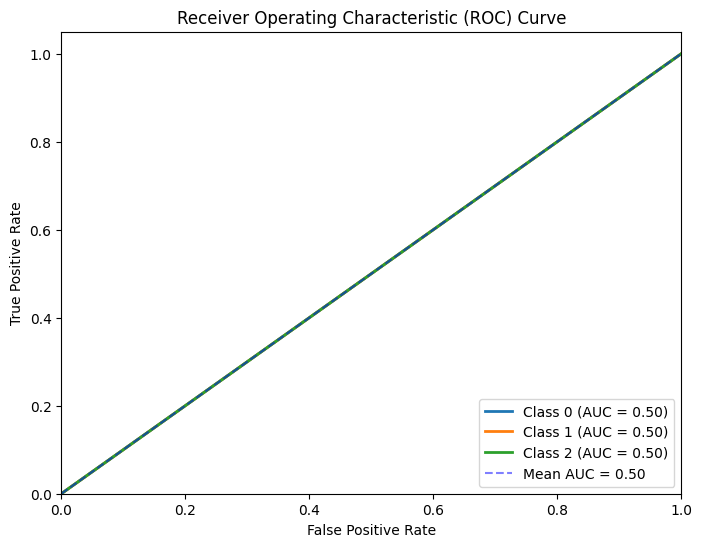

AUC per class: {0: 0.5, 1: 0.5, 2: 0.5}


In [20]:
# Calcular la curva ROC y el AUC
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Extraer los valores
values = roc_auc.values()
# Calcular la media
mean_auc = sum(values) / len(values)

# Graficar la curva ROC
plt.figure(figsize=(8, 6))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'b--', label=f"Mean AUC = {mean_auc:.2f}", alpha=0.5)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
#plt.savefig(f'../Curva_Roc/{nombre_csv}_roc_cnn.png', format='png', dpi=300)
plt.show()
print("AUC per class:", roc_auc)


In [21]:
mean_auc

0.5